In [20]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
random.seed(7)
from sklearn.metrics import mean_absolute_error

In [2]:
def ptime():
    print(datetime.datetime.now().time())
    return time.time()
start = ptime()
execution_time = ptime() - start
def ptime2(execution_time):
    print(f'{round(execution_time, 6)}s')
ptime2(execution_time)

02:28:16.380419
02:28:16.380829
0.000159s


In [10]:
def read_dataset(path):
    start = ptime()
    gc.collect()
    df = pd.read_csv(path)#change
    print(df.shape)
    df = df.dropna()
    print(df.shape)
    execution_time = ptime() - start
    ptime2(execution_time)
    return df

In [4]:
def reduce_mem_usage(df):
    start = ptime()
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.6f} MB'.format(start_mem))
    
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    for col in features:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    execution_time = ptime() - start
    ptime2(execution_time)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.6f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def mae(X_to_test, y_to_test, model_to_test):
    start = ptime()
    y_pred_test = model_to_test.predict(X_to_test)
    mae =  mean_absolute_error(y_to_test, y_pred_test)
    execution_time = ptime() - start
    ptime2(execution_time)
    return mae

In [8]:
del df
gc.collect()

14

In [11]:
df = read_dataset('../data/train_V2.csv')

02:31:57.391394
(4446966, 29)
(4446965, 29)
02:32:23.132496
25.741047s


In [12]:
df = reduce_mem_usage(df)
df.shape

02:35:38.802117
Memory usage of dataframe is 1017.829514 MB
02:35:42.466831
3.664383s
Memory usage after optimization is: 347.758417 MB
Decreased by 65.8%


(4446965, 29)

# PART 1 no matchType

# Getting X and y

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType',target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]

# Separating X and y
X = df[cols_to_fit].values
y = df['winPlacePerc'].values
# y = np.array(y).reshape(-1,1)
print(X.shape)
print(y.shape)

(4446965, 24)
(4446965,)


# SPLI

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 7)

# FITTING LGBM

In [16]:
from lightgbm import LGBMRegressor

/Users/axeljeremy/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [46]:
params = {
    'n_estimators': 10000,
    'learning_rate': 0.3, 
    'num_leaves': 33,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}
start = ptime()
model_x1 = LGBMRegressor(**params)
model_x1.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    verbose=1000,
)
execution_time = ptime() - start
ptime2(execution_time)

03:56:38.694689
[1000]	valid_0's l1: 0.0566752
[2000]	valid_0's l1: 0.0561605
[3000]	valid_0's l1: 0.0558386
[4000]	valid_0's l1: 0.055657
[5000]	valid_0's l1: 0.0555315
[6000]	valid_0's l1: 0.0554666
[7000]	valid_0's l1: 0.0554036
[8000]	valid_0's l1: 0.0553378
[9000]	valid_0's l1: 0.0552892
[10000]	valid_0's l1: 0.0552818
[11000]	valid_0's l1: 0.0552736
[12000]	valid_0's l1: 0.0552794
[13000]	valid_0's l1: 0.0552938
[14000]	valid_0's l1: 0.0552977
[15000]	valid_0's l1: 0.0552906
[16000]	valid_0's l1: 0.0552693
[17000]	valid_0's l1: 0.0552812


KeyboardInterrupt: 

In [23]:
mae_x1_train = mae(X_to_test=X_train, y_to_test= y_train,model_to_test=model_x1)
print(mae_x1_train)

02:48:34.485870
02:48:39.608686
5.122732s
0.05964717549225403


In [24]:
mae_x1_test = mae(X_to_test=X_test, y_to_test=y_test,model_to_test=model_x1 )
print(mae_x1_test)

02:49:06.600900
02:49:07.278607
0.67761s
0.059591231157103144


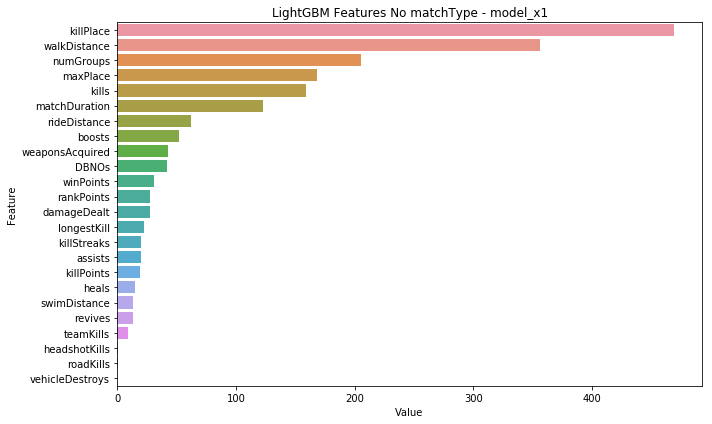

In [25]:
feature_importance = pd.DataFrame(sorted(zip(model_x1.feature_importances_, cols_to_fit)), columns=['Value','Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features No matchType - model_x1')
plt.tight_layout()

In [47]:
params = {
    'n_estimators': 16000,
    'learning_rate': 0.1, 
    'num_leaves': 33,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}
start = ptime()
model_x1 = LGBMRegressor(**params)
model_x1.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    verbose=2000,
)
execution_time = ptime() - start
ptime2(execution_time)

04:23:09.556705
[2000]	valid_0's l1: 0.0565838
[4000]	valid_0's l1: 0.0559841
[6000]	valid_0's l1: 0.0556686
[8000]	valid_0's l1: 0.0554168
[10000]	valid_0's l1: 0.0552298
[12000]	valid_0's l1: 0.0551121
[14000]	valid_0's l1: 0.0550015
[16000]	valid_0's l1: 0.0548825
[18000]	valid_0's l1: 0.0548189
[20000]	valid_0's l1: 0.0547528
[22000]	valid_0's l1: 0.054727
[24000]	valid_0's l1: 0.0546954
[26000]	valid_0's l1: 0.0546382
[28000]	valid_0's l1: 0.054581
[30000]	valid_0's l1: 0.0545286
[32000]	valid_0's l1: 0.0544911
05:25:30.907642
3741.351482s


In [81]:
params = {
    'n_estimators': 200,
    'learning_rate': 0.35, 
    'num_leaves': 35,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'reg_lambda' : 0.07,
    'verbose': -1,
}
start = ptime()
model_x1 = LGBMRegressor(**params)
model_x1.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    verbose=20,
)
execution_time = ptime() - start
ptime2(execution_time)

10:43:50.636450
[20]	valid_0's l1: 0.062321
[40]	valid_0's l1: 0.0600468
[60]	valid_0's l1: 0.0594213
[80]	valid_0's l1: 0.058939
[100]	valid_0's l1: 0.0586545
[120]	valid_0's l1: 0.0584981
[140]	valid_0's l1: 0.0583798
[160]	valid_0's l1: 0.0582696
[180]	valid_0's l1: 0.0581388
[200]	valid_0's l1: 0.0579901
10:44:25.738597
35.101905s


In [82]:
params = {
    'n_estimators': 200,
    'learning_rate': 0.35, 
    'num_leaves': 35,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'reg_lambda' : 0.09,
    'verbose': -1,
}
start = ptime()
model_x1 = LGBMRegressor(**params)
model_x1.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    verbose=20,
)
execution_time = ptime() - start
ptime2(execution_time)

10:45:21.203643
[20]	valid_0's l1: 0.0623211
[40]	valid_0's l1: 0.0600468
[60]	valid_0's l1: 0.0594213
[80]	valid_0's l1: 0.058939
[100]	valid_0's l1: 0.0586816
[120]	valid_0's l1: 0.0584841
[140]	valid_0's l1: 0.0583625
[160]	valid_0's l1: 0.0582162
[180]	valid_0's l1: 0.0580928
[200]	valid_0's l1: 0.0579613
10:45:57.652062
36.448425s


In [112]:
params = {
    'n_estimators': 220,
    'learning_rate': 0.3, 
    'num_leaves': 31,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'reg_lambda' : 0.2,
    'verbose': -1,
}
start = ptime()
model_x1 = LGBMRegressor(**params)
model_x1.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    verbose=20,
)
execution_time = ptime() - start
ptime2(execution_time)

11:17:18.608612
[20]	valid_0's l1: 0.0632209
[40]	valid_0's l1: 0.0605182
[60]	valid_0's l1: 0.0596108
[80]	valid_0's l1: 0.0591561
[100]	valid_0's l1: 0.0589005
[120]	valid_0's l1: 0.0586272
[140]	valid_0's l1: 0.05847
[160]	valid_0's l1: 0.0583103
[180]	valid_0's l1: 0.0582323
[200]	valid_0's l1: 0.0581063
[220]	valid_0's l1: 0.058031
11:17:57.502080
38.893487s


In [99]:
mae_x1_test = mae(X_to_test=X_test, y_to_test=y_test,model_to_test=model_x1 )
print(mae_x1_test)

11:04:07.978546
11:04:09.029791
1.051126s
0.0579613089595354


In [90]:
params = {
    'n_estimators': 200,
    'learning_rate': 0.5, 
    'num_leaves': 35,
    'objective': 'regression', 
    'metric': 'mae',
    'reg_lambda' :  0.0000001 ,
    'verbose': -1,
}
start = ptime()
model_x1 = LGBMRegressor(**params)
model_x1.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    verbose=20,
)
execution_time = ptime() - start
ptime2(execution_time)

10:52:42.749284
[20]	valid_0's l1: 0.0620269
[40]	valid_0's l1: 0.0602751
[60]	valid_0's l1: 0.0596538
[80]	valid_0's l1: 0.0592945
[100]	valid_0's l1: 0.058893
[120]	valid_0's l1: 0.0587384
[140]	valid_0's l1: 0.0584752
[160]	valid_0's l1: 0.0583262
[180]	valid_0's l1: 0.0581968
[200]	valid_0's l1: 0.0581082
10:53:14.762688
32.013423s


In [115]:
params = {
    'n_estimators': 100,
    'learning_rate': 0.5, 
    'num_leaves': 35,
    'objective': 'regression', 
    'metric': 'mae',
    'reg_lambda' : 0.1,
    'reg_alpha' : 0.0001,
    'verbose': -1,
}
start = ptime()
model_x1 = LGBMRegressor(**params)
model_x1.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    verbose=50,
)
execution_time = ptime() - start
ptime2(execution_time)
#0.058893
#0.0587465

11:23:05.462099
[50]	valid_0's l1: 0.0599631
[100]	valid_0's l1: 0.0587465
11:23:26.201583
20.739714s


In [73]:
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 33,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}
start = ptime()
model_x1 = LGBMRegressor(**params)
model_x1.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    verbose=20,
)
execution_time = ptime() - start
ptime2(execution_time)

10:30:51.152400
[20]	valid_0's l1: 0.0631624
[40]	valid_0's l1: 0.0604073
[60]	valid_0's l1: 0.059632
[80]	valid_0's l1: 0.0591652
[100]	valid_0's l1: 0.058846
10:31:14.227508
23.074821s
